In [8]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np

train_path= "chest_xray/train"
test_path= "chest_xray/test"
valid_path = "chest_xray/val"

In [9]:
#The batch refers to the number of training examples utilized in one
batch_size=  16
#Image Details
img_height= 500
img_width= 500

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
image_gen = ImageDataGenerator(
                                   rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                               )  
test_data_gen = ImageDataGenerator(rescale = 1./255)
train = image_gen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=batch_size
                                      )
test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',shuffle=False,
      class_mode='binary',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary', 
      batch_size=batch_size
      )

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


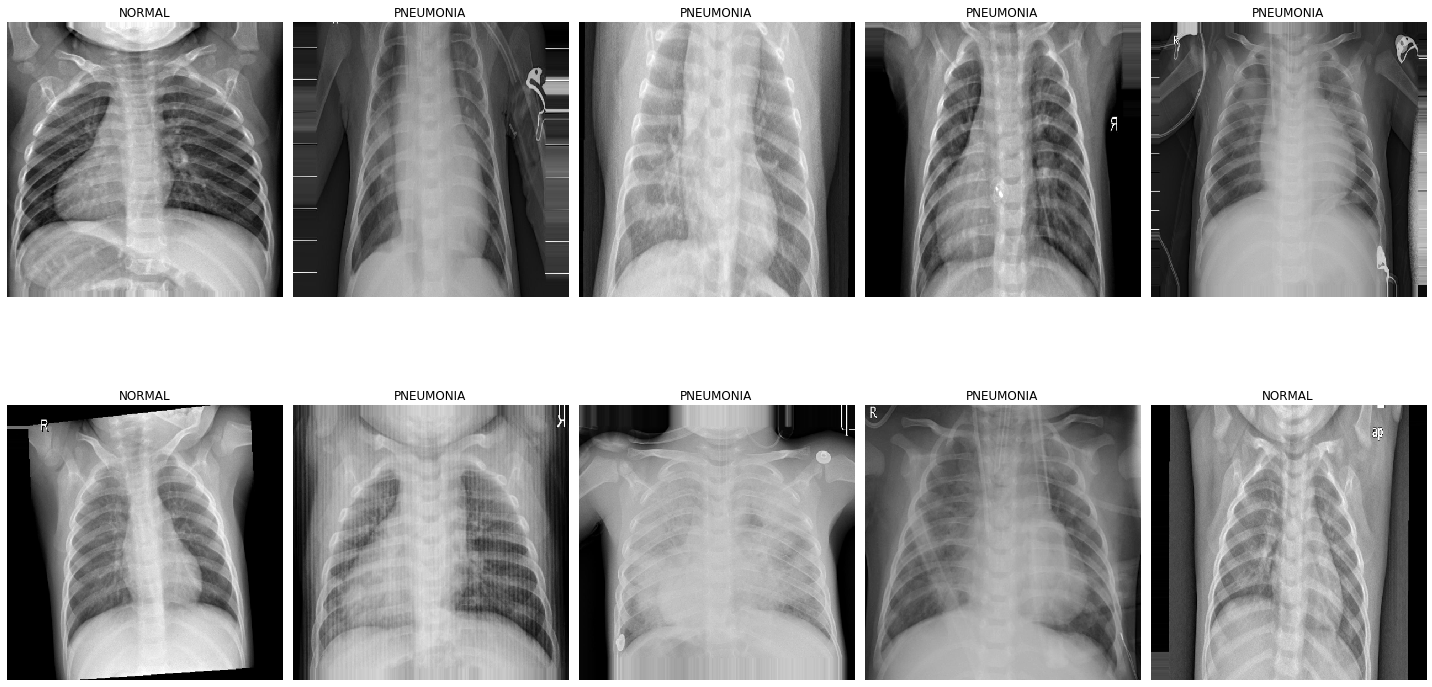

In [11]:
plt.figure(figsize=(20, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]        
        dic = {0:'NORMAL', 1:'PNEUMONIA'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()


# CONVOLUTIONAL NETWORK

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [13]:
cnn = Sequential()

cnn.add(Conv2D(32, (3,3), activation = "relu", input_shape = (img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2,2)))
cnn.add(Conv2D(32, (3,3), activation= "relu", input_shape = (img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size= (2,2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Flatten())

cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))

cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [14]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 498, 498, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 249, 249, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 247, 247, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 123, 123, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 121, 121, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 58, 58, 64)        1

In [15]:
from tensorflow.keras.utils import plot_model
import pydot
import graphviz
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [16]:
early = EarlyStopping(monitor = "val_loss", mode= "min", patience = 3)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss', patience= 2, verbose = 1, factor=0.3, min_lr=0.000001)
callback_list = [early, learning_rate_reduction]

In [17]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', np.unique(train.classes), train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


{0: 1.9448173005219984, 1: 0.6730322580645162}


In [18]:
cnn.fit(train, epochs=25, validation_data=valid, class_weight=cw, callbacks= callback_list)

Epoch 1/25
326/326 [==============================] - 763s 2s/step - loss: 0.5271 - accuracy: 0.6465 - val_loss: 1.8913 - val_accuracy: 0.6250
Epoch 2/25
326/326 [==============================] - 775s 2s/step - loss: 0.2619 - accuracy: 0.8956 - val_loss: 0.9677 - val_accuracy: 0.6250
Epoch 3/25
326/326 [==============================] - 773s 2s/step - loss: 0.2048 - accuracy: 0.9202 - val_loss: 2.2794 - val_accuracy: 0.6250
Epoch 4/25
326/326 [==============================] - 818s 3s/step - loss: 0.1785 - accuracy: 0.9349 - val_loss: 1.4396 - val_accuracy: 0.6250

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 5/25
326/326 [==============================] - 750s 2s/step - loss: 0.1651 - accuracy: 0.9361 - val_loss: 1.2124 - val_accuracy: 0.6250


<AxesSubplot:>

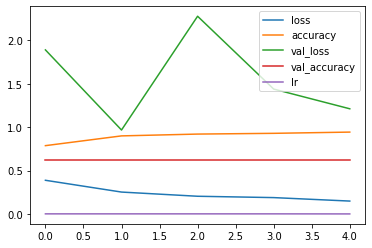

In [19]:
pd.DataFrame(cnn.history.history).plot()

In [20]:
test_accu= cnn.evaluate(test)
print("The test accuracy is : ", test_accu[1]*100, '%')

39/39 [==============================] - 22s 567ms/step - loss: 0.4818 - accuracy: 0.9054
The test accuracy is :  90.54487347602844 %


In [21]:
preds = cnn.predict(test, verbose= 1)

39/39 [==============================] - 20s 498ms/step


In [22]:
predictions =preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

<AxesSubplot:>

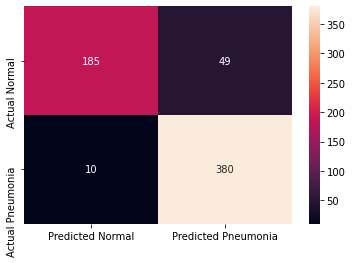

In [23]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])

import seaborn as sns
sns.heatmap(cm , annot = True , fmt = "d")

In [24]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.95      0.79      0.86       234
   PNEUMONIA       0.89      0.97      0.93       390

    accuracy                           0.91       624
   macro avg       0.92      0.88      0.90       624
weighted avg       0.91      0.91      0.90       624



## VISUALIZE PREDICITONS 

(624, 500, 500, 1)
(624,)


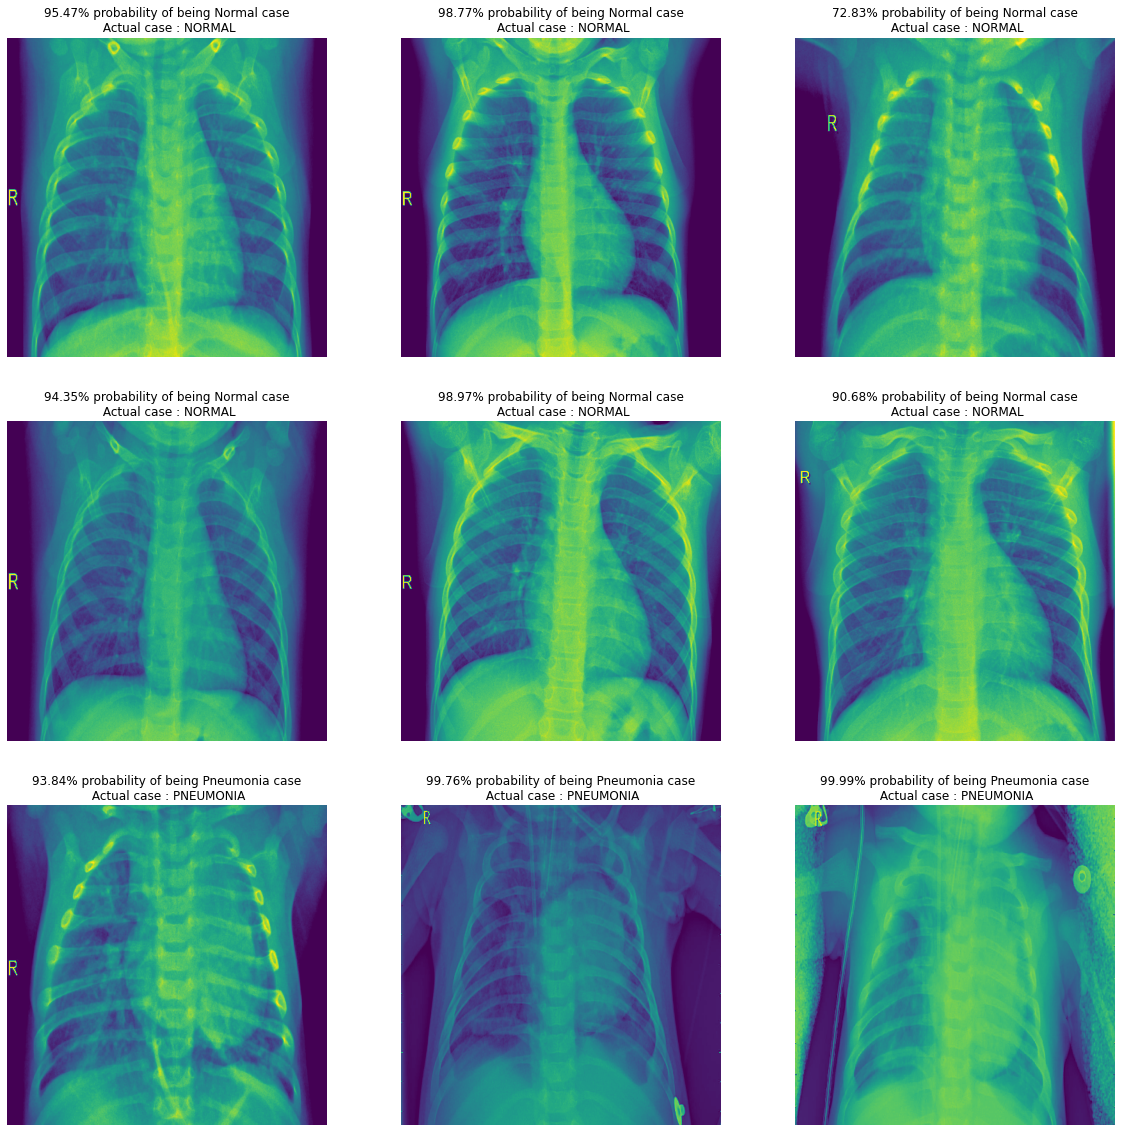

In [25]:
test.reset()
x = np.concatenate([test.next() [0] for i in range(test.__len__() )])
y = np.concatenate([test.next() [1] for i in range(test.__len__() )])

print(x.shape)
print(y.shape)

dic = {0:'NORMAL', 1:'PNEUMONIA'}
plt.figure(figsize=(20,20))
for i in range(0+228, 9+228):
  plt.subplot(3, 3, (i-228)+1)
  if preds[i, 0] >= 0.5: 
      out = ('{:.2%} probability of being Pneumonia case'.format(preds[i][0]))
  else: 
      out = ('{:.2%} probability of being Normal case'.format(1-preds[i][0]))   
  plt.title(out+"\n Actual case : "+ dic.get(y[i]))    
  plt.imshow(np.squeeze(x[i]))
  plt.axis('off')
plt.show()

## TEST SELF X RAY

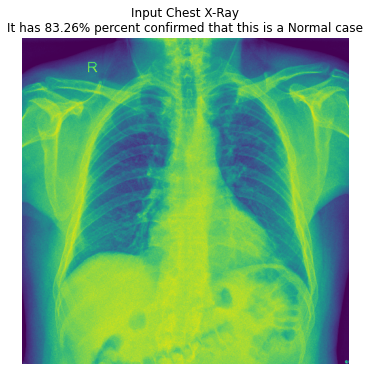

In [26]:
Image_path = 'EX_TEST/TEST_IMAGE.png'

from tensorflow.keras.preprocessing import image
load_img = image.load_img(Image_path, target_size=(500, 500),color_mode='grayscale')

# Preprocessing the image
pp_img = image.img_to_array(load_img)
pp_img = pp_img/255
pp_img = np.expand_dims(pp_img, axis=0)

#predict
img_preds= cnn.predict(pp_img)
#print
plt.figure(figsize=(6,6))
plt.axis('off')
if img_preds >= 0.5: 
    out = ('It has {:.2%} percent confirmed that this is a Pneumonia case'.format(img_preds[0][0]))
    
else: 
    out = ('It has {:.2%} percent confirmed that this is a Normal case'.format(1-img_preds[0][0]))
    

plt.title("Input Chest X-Ray\n"+out)  
plt.imshow(np.squeeze(pp_img))
plt.show()

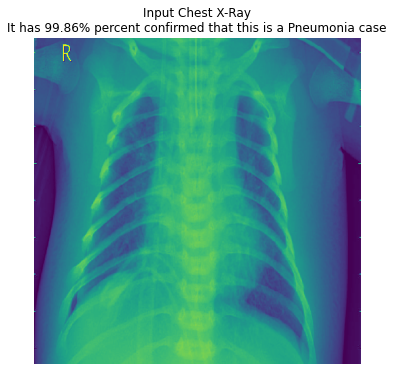

In [30]:
Image_path = 'EX_TEST/TEST_IMAGE_2.jpeg'

from tensorflow.keras.preprocessing import image
load_img = image.load_img(Image_path, target_size=(500, 500),color_mode='grayscale')

#Preprocessing the image
pp_img = image.img_to_array(load_img)
pp_img = pp_img/255
pp_img = np.expand_dims(pp_img, axis=0)

#predict
img_preds= cnn.predict(pp_img)
#print
plt.figure(figsize=(6,6))
plt.axis('off')
if img_preds >= 0.5: 
    out = ('It has {:.2%} percent confirmed that this is a Pneumonia case'.format(img_preds[0][0]))
    
else: 
    out = ('It has {:.2%} percent confirmed that this is a Normal case'.format(1-img_preds[0][0]))
    

plt.title("Input Chest X-Ray\n"+out)  
plt.imshow(np.squeeze(pp_img))
plt.show()